# Grundmodell
## Elektrisches Netzwerk 

Gruppe A

Stand: 06.06.2019

------------------------------

## Wichtige Infos:

### theta[0,x]: Phase des Oszillators x (THETA)

### theta[1,x]: Ableitung der Phase des Oszillators x (THETA PUNKT)

In [72]:
#Nummer des Durchlaufs oder Name definieren (für Abspeicherung der Bilder)
bildname = "test"

-----------------

## Teil 0 - Importieren von Packages

In [2]:
#Importiere mehrere Packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

--------

## Teil 1 - Initialisieren und Anfangswerte

In [76]:
#Feste Zahlen:

#-------------------------- 
#SIMULATIONSPARAMETER

#Anzahl der Maximal-Schritte der Simulation
anzahlschritte = 50000
#Nach wievielen Schritten ein Bild gespeichert werden soll:
output = 1000

#Schrittweite in der Zeit
dt = 0.01


#-------------------------- 
#MODELLPARAMETER

#Anzahl der Oszillatoren
N = 88

#Koppungsstärke (wird noch auf Adjazenzmatrix draufmultipliziert)
Kopplung = 1

#Faktor vor erster Ableitung
alpha = 0.1

#Adjazenz-Matrix laden
adjazenzmatrix = np.load("romAdj.npy")

#Positions-Matrix laden
position = np.load("romPos.npy")

#Array für Thetas erstellen (jeweils mit zwei Einträgen pro Oszillator)
theta = np.ndarray(shape=(N,2))
theta_temp = np.ndarray(shape=(N,2)) #hilfsmatrix um synchronisation zu berechnen

#Leistung P(j) (kann auch wie Adjazenzmatrix eingelesen werden)
P = np.array([0.]*N)

#Synchronisations-Array
synchronisiert = np.array(["false"]*N)

In [68]:
#Initialisierungsfunktion definieren

def initialisieren():
    #Phasen zufällig verteilen und Änderung der Phasen auf Anfangswert 0 setzen
    temp_verteilung = np.random.random(N)*np.pi
    for i in range(0,N):
        theta[i,0] = temp_verteilung[i]
        theta[i,1] = 0
    
    
    #Synchronisierungsparameter zurücksetzen
    synchronisiert[:] = "false"
    #Theta_temp (für synchro) zurücksetzen
    theta_temp = theta
    
    #überprüfen ob Leistung der Vorraussetzung für das Modell entspricht
    summe = 0
    for i in range(0,N):
        summe = summe + P[i]
    if(summe != 0):
        print("Leistung überprüfen! ","Summe aller P:",summe)
    
    print("Erfolgreich initialisiert.")

In [69]:
#Funktion um Leistung zu verteilen (überflüssig wenn P-Array festgelegt wird!)
def iniLeistung():
    #Leistung festsetzen:
    for i in range(0,int(N/2)):
        P[i] = 1
        P[2*i] = -1
        P[2*i +1] = -1
    P[N-1] = 1
    print(P)
    
    #überprüfen ob Leistung der Vorraussetzung für das Modell entspricht
    summe = 0
    for i in range(0,N):
        summe = summe + P[i]
    if(summe != 0):
        print("Leistung überprüfen! ","Summe aller P:",summe)
    else:
        print("Leistung erfolgreich initialisiert.")

-------

## Teil 2 - Formeln und Funktionen

#### Inhalt:
1. Ordnungsparameter
2. Kuramoto-Funktion
3. Runge-Kutta-Verfahren
4. Zeichnungsfunktion

In [62]:
#1. Ordnungsparameter bestimmen
def ordnung(N,theta):
    #bertrachte Imaginärteil und Realteil des Parameters gesondert
    tempRe = 0
    tempIm = 0
    
    #Schleife um Summe der Theta zu berechnen
    for i in range(0,N):
        tempRe = tempRe + np.cos(theta[i,0])
        tempIm = tempIm + np.sin(theta[i,0])
        
    #Normieren um Mittelwert zu bekommen:
    tempRe = tempRe / N
    tempIm = tempIm / N
    
    #r und Phi berechnen
    r = (tempIm**2 + tempRe**2)**(1/2)
    phi = np.arccos(tempRe)
    
    return r,phi

In [63]:
#Kuramoto-Funktion (auf Basis von Fennas Vorlage)
def kuramoto(theta,power = P,adjamatrix = adjazenzmatrix):
    
    #Zwischenwerte auf 0 setzen
    sum_kop= np.array([0.0]*N)
    res = np.ndarray(shape=(N,2))
    m=0
    j=0
    l=0
    
    #Schleife um die Summen für alle Werte zu bekommen (sum_kop[m] ist Summe der Kopplung für Oszillator m)
    for m,j,l in zip(*sp.find(adjamatrix)):
        sum_kop[m] +=Kopplung*l*np.sin(theta[j,0] - theta[m,0])
        
    #Funktionswerte ermitteln (in 2d)
    res[:,0]= theta[:,1] #Ableitung von Theta ist Theta-Punkt
    res[:,1]= power - alpha*theta[:,1] + sum_kop #Ableitung von Theta-Punkt entspricht Kuramoto-Gleichung

    return res

In [64]:
#Runge-Kutta-4 Verfahren
def rungekutta4(funktion, x, h = dt):
    #Faktoren berechnen
    k1 = funktion(x)    
    k2 = funktion(x + h/2 * k1)   
    k3 = funktion(x + h/2 * k2)
    k4 = funktion(x + h * k3)
    
    #neuen Funktionswert berechnen (mehrdimensional)
    return x + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [71]:
#Hilfsfunktion zum zeichnen
def zeichne(theta, r, phi, synchronisiert, adjamatrix = adjazenzmatrix):
    #Aufbau des Schaubilds
    fig, axs = plt.subplots(1, 2, figsize=(13, 6)) #erzeugt zwei Bilder nebeneinander
    axs[0].plot() #erzeugt plot im ersten Bild
    axs[1].plot() #erzeugt plot im zweiten Bild

    plt.figure("phases")

    
    #Kreis plotten
    an = np.linspace(0,2*np.pi,100)
    axs[1].plot(np.sin(an),np.cos(an), color="black")

    #Ordnungsparameter
    axs[1].arrow(0,0,r*np.cos(phi),r*np.sin(phi),head_width=0.05, color="black")

    #Verbindungslinien plotten
    m=0
    j=0
    l=0
    for m,j,l in zip(*sp.find(adjamatrix)):
        axs[0].plot(position[[m,j],0],position[[m,j],1], "-", color="black",linewidth=1.05)


    #Schleife um alle Punkte (Oszillatoren) zu plotten
    for l in range(0,N):
        #Synchronisierung checken
        if (synchronisiert[l] == "true"): 
            axs[0].plot(position[l,0],position[l,1],"o", color="red")
            axs[1].plot(np.cos(theta[l,0]),np.sin(theta[l,0]),"o", color="red")
        else:
            #sonst Punkt normal plotten
            axs[0].plot(position[l,0],position[l,1],"o", color="blue")
            #wenn nicht synchronisiert Oszi auf Kreis (zweiter Index 0, da Phase geplottet wird)
            axs[1].plot(np.cos(theta[l,0]),np.sin(theta[l,0]),"o", color="blue")
            


    #zeichnen und Abspeichern
    plt.draw()
    fileName = "video/"+bildname+"_"+str(i)+".png"
    fig.savefig(fileName,dpi=300)
    plt.show(block=False)

    plt.pause(0.01)

------

## Teil 3 - Hauptzelle

Erfolgreich initialisiert.
0 %
Synchro: 0.636


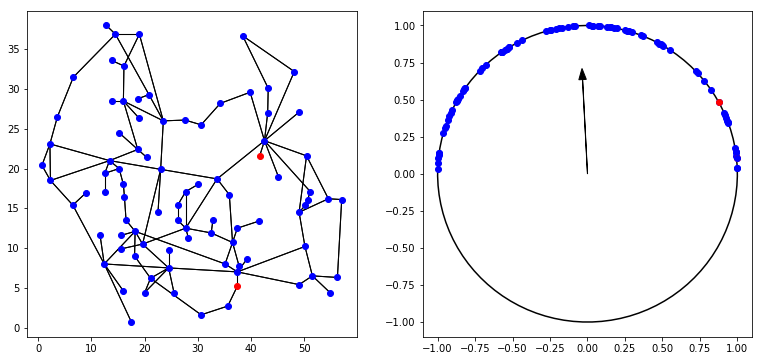

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 0.925


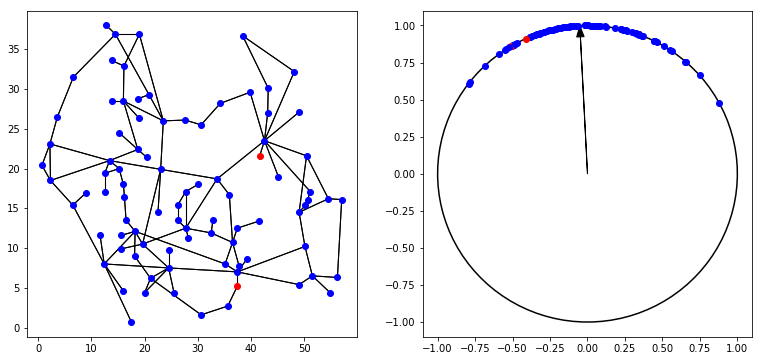

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 0.975


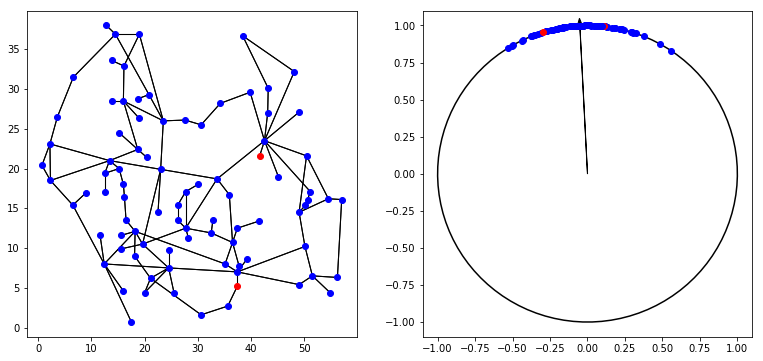

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 0.99


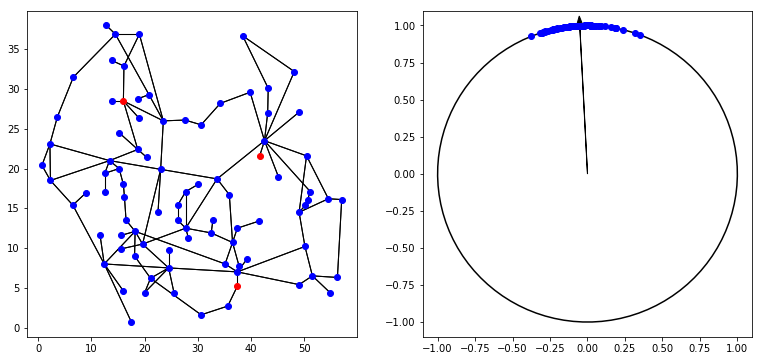

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 0.996


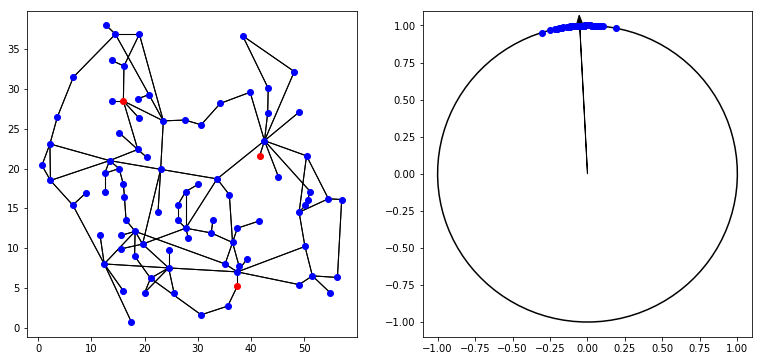

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 0.999


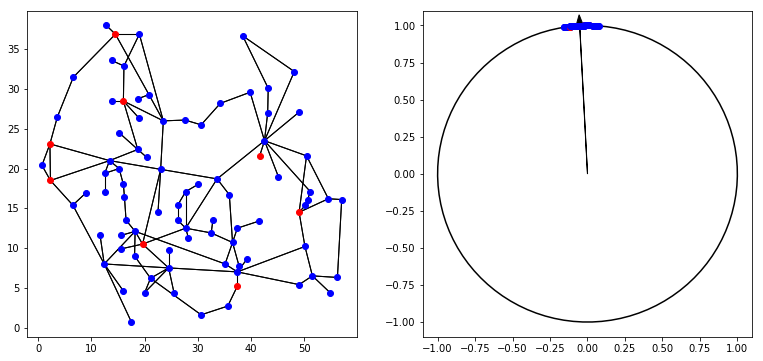

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


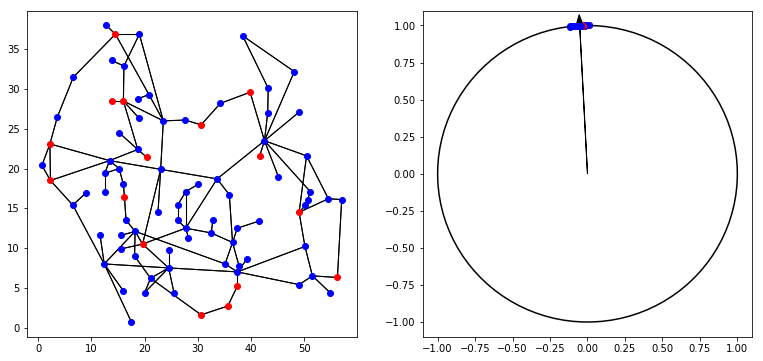

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


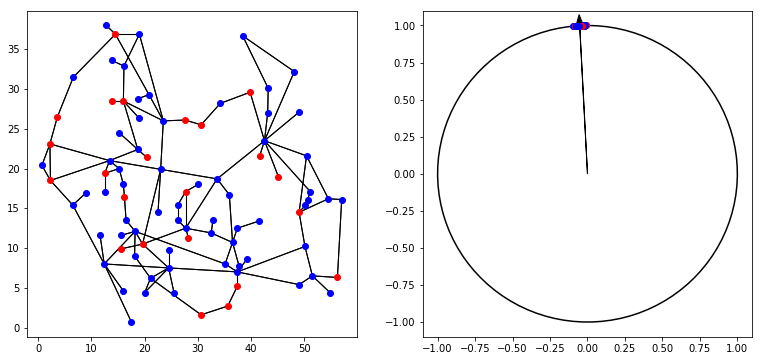

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


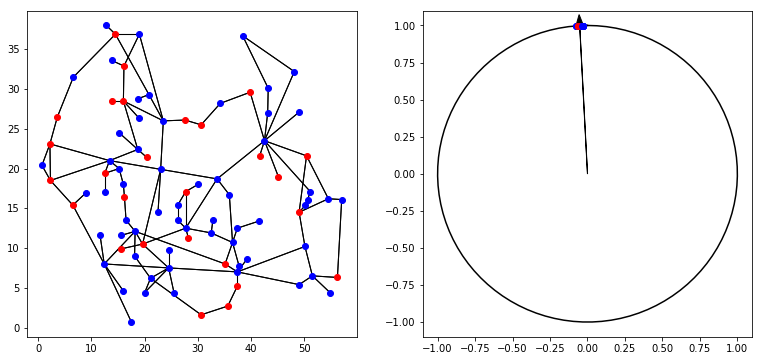

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


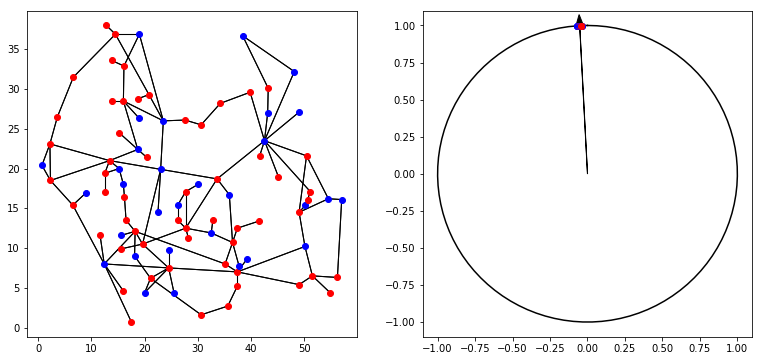

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


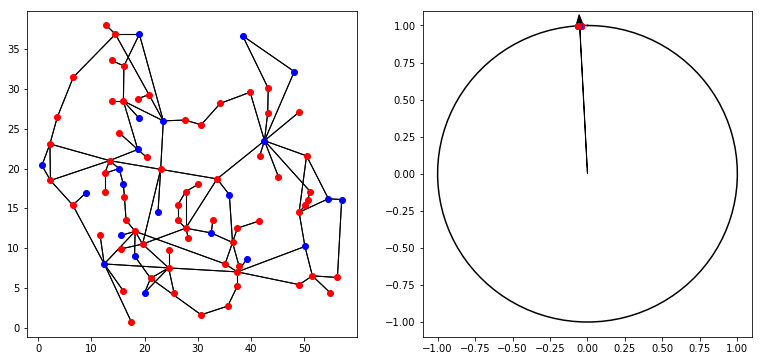

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


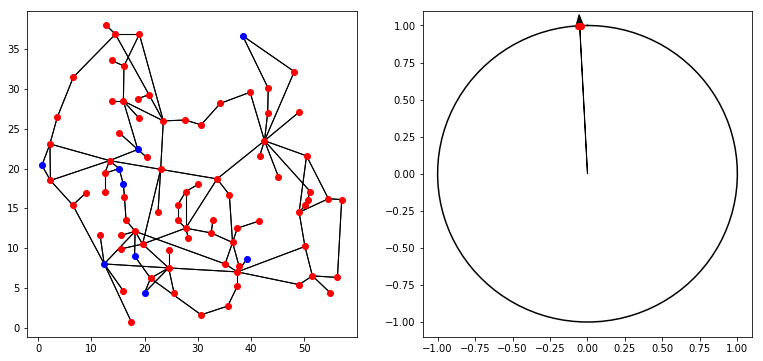

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


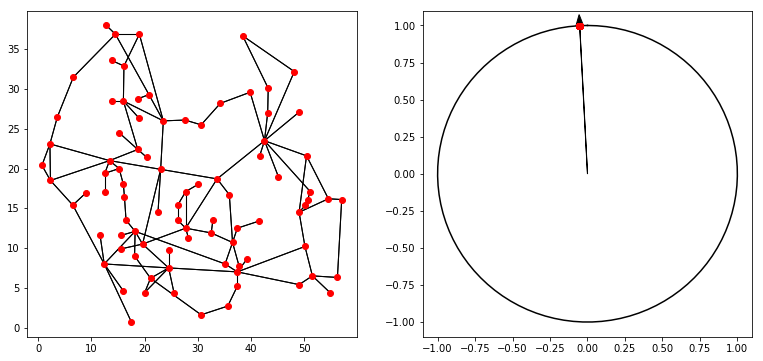

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


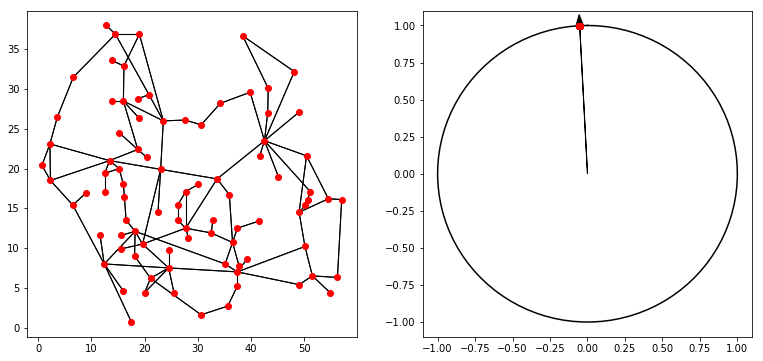

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


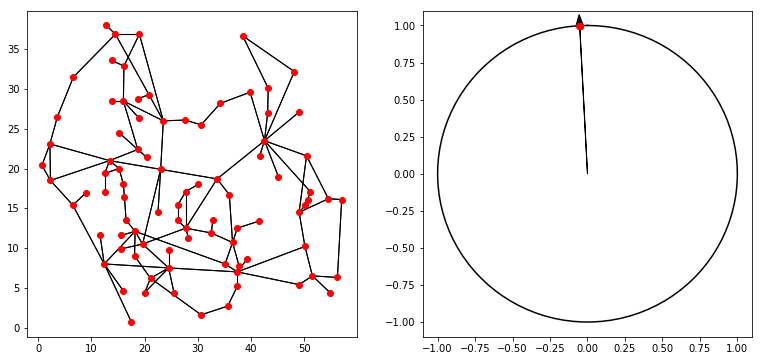

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


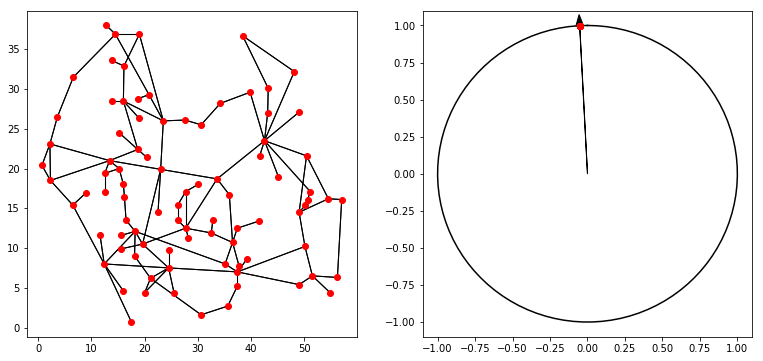

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


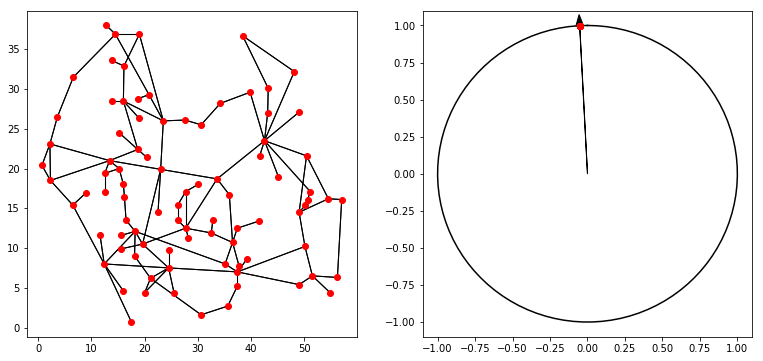

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Synchro: 1.0


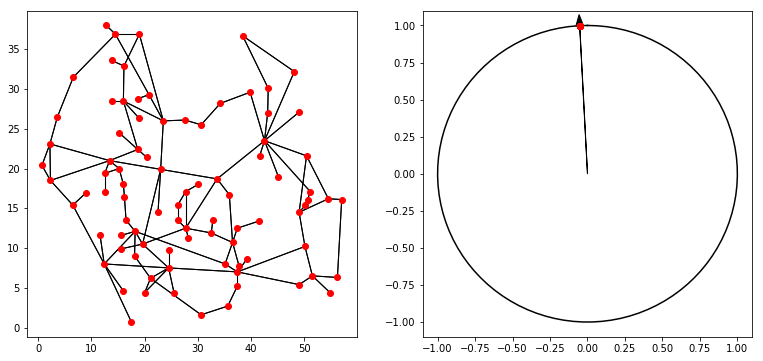

0 %
10 %
20 %
30 %
40 %
50 %


KeyboardInterrupt: 

In [75]:
#zunächst zurücksetzen
initialisieren()
#Einfügen falls Leistung zurückgesetzt werden soll:
#iniLeistung()

zaehler = 0

#dann berechnen
for i in range(0,anzahlschritte):
    #-------------------------------------------
    #RECHNEN

    theta = rungekutta4(kuramoto,theta,dt)

    if (i%(output/10) == 0): #um Zwischenstand anzuzeigen
        print(zaehler,"%")
        zaehler += 10
    if (i%output == 0): #um Bilder zu plotten
        zaehler = 0
        
        #Ordnungsparameter berechnen
        r, phi = ordnung(N,theta)
        print("Synchro:", round(r,5))
        
        #Synchronisation ermitteln
        for o in range(0,N):
            #überprüfen ob 
            if (abs(theta_temp[o,1]- theta[0,1]) <= 0.01):
                synchronisiert[o] = "true"
            
        #theta_temp auf theta setzen für den nächsten Vergleich
        theta_temp = theta
        
        #------------------------------------------
        #PLOTTEN
        
        #Zeichnen
        zeichne(theta, r, phi, synchronisiert, adjamatrix = adjazenzmatrix)